In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
import spacy
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

In [5]:
df_train=pd.read_csv('/content/drive/MyDrive/Data_AI/Twitter/twitter_training.csv')
df_val=pd.read_csv('/content/drive/MyDrive/Data_AI/Twitter/twitter_validation.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
df_train['Positive'].value_counts()

Positive
Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: count, dtype: int64

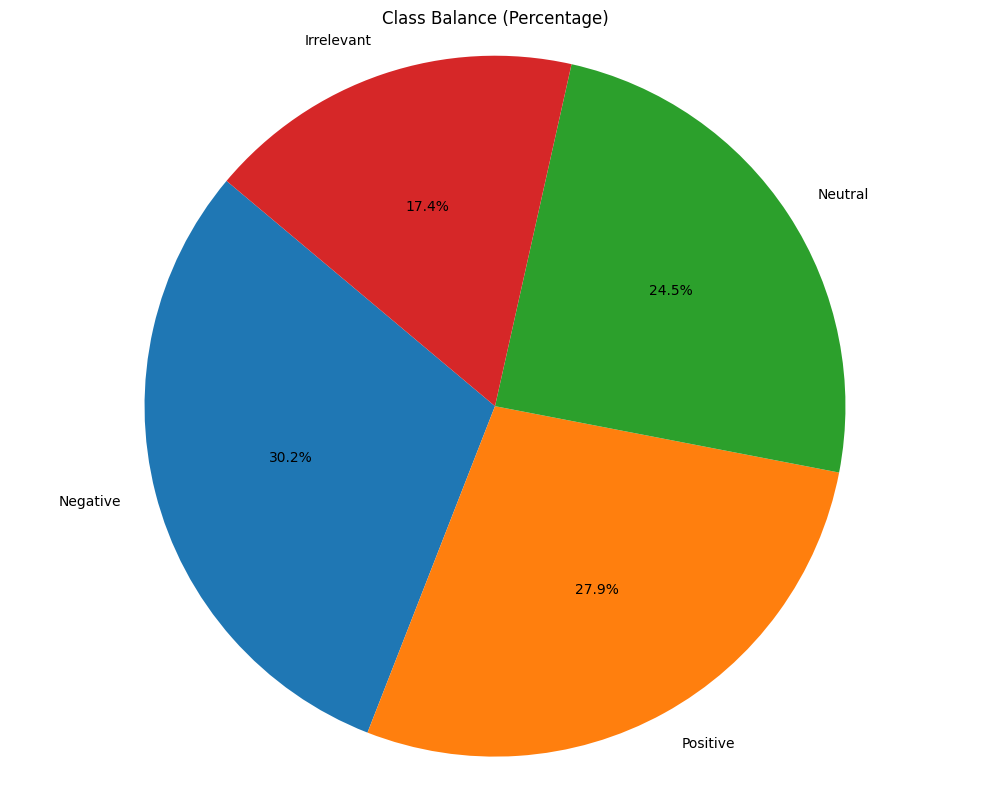

In [8]:
# Calculate class counts
class_counts = df_train['Positive'].value_counts().reset_index()
class_counts.columns = ['Class', 'Count']

# Calculate the total number of images in train_df
total_images = len(df_train)

# Calculate the percentage for each class based on the total number of images
class_counts['Percentage'] = (class_counts['Count'] / total_images) * 100

# Sort the dataframe by count
class_counts = class_counts.sort_values(by='Count', ascending=False)

# Create the pie chart using matplotlib
plt.figure(figsize=(10, 8))
plt.pie(class_counts['Percentage'], labels=class_counts['Class'], autopct='%1.1f%%', startangle=140)
plt.title('Class Balance (Percentage)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()

In [9]:
nlp = spacy.load("en_core_web_sm")

def preprocess(text):
    if pd.isnull(text):
        return ""
    # Tokenize the text and remove stop words and punctuation
    doc = nlp(text)
    filtered_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(filtered_tokens) #Bag of words

In [10]:
df_train.rename(columns={"im getting on borderlands and i will murder you all ,": "text"}, inplace=True)

In [11]:
df_train['text']=df_train['text'].apply(preprocess)

In [12]:
df_train

,2401,Borderlands,Positive,text
0,2401,Borderlands,Positive,come border kill
1,2401,Borderlands,Positive,m get borderland kill
2,2401,Borderlands,Positive,m come borderland murder
3,2401,Borderlands,Positive,m get borderland 2 murder
4,2401,Borderlands,Positive,m get borderland murder
...,...,...,...,...
74676,9200,Nvidia,Positive,realize Windows partition Mac like 6 year Nvid...
74677,9200,Nvidia,Positive,realize Mac window partition 6 year Nvidia dri...
74678,9200,Nvidia,Positive,realize window partition Mac 6 year Nvidia dri...
74679,9200,Nvidia,Positive,realize window partition Mac like 6 year Nvidi...


In [13]:
le = LabelEncoder()
df_train['Positive'] = le.fit_transform(df_train['Positive'])

In [14]:
df_train=df_train.drop(['Borderlands','2401'],axis=1)
df_train

,Positive,text
0,3,come border kill
1,3,m get borderland kill
2,3,m come borderland murder
3,3,m get borderland 2 murder
4,3,m get borderland murder
...,...,...
74676,3,realize Windows partition Mac like 6 year Nvid...
74677,3,realize Mac window partition 6 year Nvidia dri...
74678,3,realize window partition Mac 6 year Nvidia dri...
74679,3,realize window partition Mac like 6 year Nvidi...


In [15]:
df_val=df_val.drop(['3364','Facebook'],axis=1)
df_val

,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [16]:
df_val.columns

Index(['Irrelevant', 'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣'], dtype='object')

In [17]:
df_val.rename(columns={"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣": "text"}, inplace=True)

In [18]:
df_val

,Irrelevant,text
0,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Negative,@Microsoft Why do I pay for WORD when it funct...
2,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Neutral,Now the President is slapping Americans in the...
4,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...
...,...,...
994,Irrelevant,⭐️ Toronto is the arts and culture capital of ...
995,Irrelevant,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...
996,Positive,Today sucked so it’s time to drink wine n play...
997,Positive,Bought a fraction of Microsoft today. Small wins.


In [19]:
df_val['text']=df_val['text'].apply(preprocess)
df_val

,Irrelevant,text
0,Neutral,BBC News Amazon boss Jeff Bezos reject claim c...
1,Negative,@microsoft pay word function poorly @samsungu ...
2,Negative,csgo matchmaking closet hacking truly awful game
3,Neutral,President slap Americans face commit unlawful ...
4,Negative,hi @eahelp Madeleine McCann cellar past 13 yea...
...,...,...
994,Irrelevant,⭐ ️ Toronto art culture capital Canada wonder ...
995,Irrelevant,ACTUALLY good tot bring viewer \n\n people get...
996,Positive,today suck time drink wine n play borderland s...
997,Positive,buy fraction Microsoft today small win


In [20]:
df_val['Irrelevant'] = le.fit_transform(df_val['Irrelevant'])
df_val

,Irrelevant,text
0,2,BBC News Amazon boss Jeff Bezos reject claim c...
1,1,@microsoft pay word function poorly @samsungu ...
2,1,csgo matchmaking closet hacking truly awful game
3,2,President slap Americans face commit unlawful ...
4,1,hi @eahelp Madeleine McCann cellar past 13 yea...
...,...,...
994,0,⭐ ️ Toronto art culture capital Canada wonder ...
995,0,ACTUALLY good tot bring viewer \n\n people get...
996,3,today suck time drink wine n play borderland s...
997,3,buy fraction Microsoft today small win


In [21]:
df_val.rename(columns={"Irrelevant": "Positive"}, inplace=True)

In [22]:
combined_df = pd.concat([df_train, df_val], ignore_index=True)
combined_df

,Positive,text
0,3,come border kill
1,3,m get borderland kill
2,3,m come borderland murder
3,3,m get borderland 2 murder
4,3,m get borderland murder
...,...,...
75675,0,⭐ ️ Toronto art culture capital Canada wonder ...
75676,0,ACTUALLY good tot bring viewer \n\n people get...
75677,3,today suck time drink wine n play borderland s...
75678,3,buy fraction Microsoft today small win


In [23]:
X_train, X_test, y_train, y_test = train_test_split(combined_df['text'], combined_df['Positive'],
                                                    test_size=0.2, random_state=42, stratify=combined_df['Positive'])

In [24]:
classifiers = [
    ('MultinomialNB', MultinomialNB()),
    ('RandomForest', RandomForestClassifier()),
    ('LinearSVC', LinearSVC()),
    ('LogisticRegression', LogisticRegression(max_iter=1000))
]

In [25]:
names = []
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

In [28]:
# Iterate over the classifiers
for classifier_name, classifier in classifiers:
    # Create a pipeline
    clf = Pipeline([
        ('vectorizer_tri_grams', TfidfVectorizer()),
        (classifier_name, classifier)
    ])

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions
    pred = clf.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average='weighted')
    recall = recall_score(y_test, pred, average='weighted')
    f1 = f1_score(y_test, pred, average='weighted')

    # Store metrics
    names.append(classifier_name)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

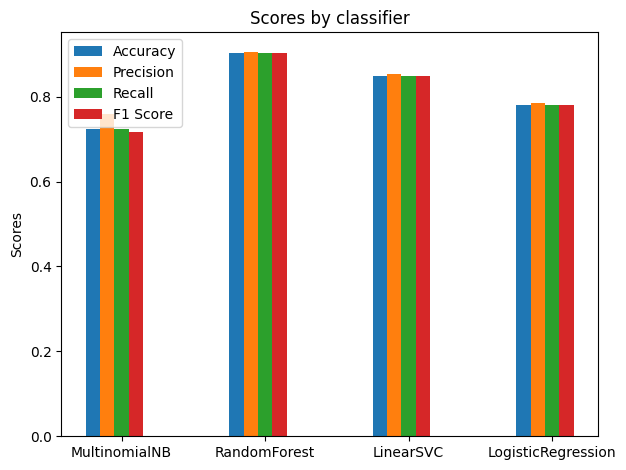

In [29]:
# Plot metrics
x = np.arange(len(names))
width = 0.1

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x - width, precision_scores, width, label='Precision')
rects3 = ax.bar(x, recall_scores, width, label='Recall')
rects4 = ax.bar(x + width, f1_scores, width, label='F1 Score')

ax.set_ylabel('Scores')
ax.set_title('Scores by classifier')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

fig.tight_layout()

plt.show()

In [30]:
# Print the names of the classifiers and their corresponding scores
for name, accuracy, precision, recall, f1 in zip(names, accuracy_scores, precision_scores, recall_scores, f1_scores):
    print(f"{name}:")
    print(f"  Accuracy: {accuracy * 100} %")
    print(f"  Precision: {precision* 100} %")
    print(f"  Recall: {recall* 100} %")
    print(f"  F1 Score: {f1* 100} %\n")

MultinomialNB:
  Accuracy: 72.33747357293869 %
  Precision: 75.9283460919796 %
  Recall: 72.33747357293869 %
  F1 Score: 71.67837399935438 %

RandomForest:
  Accuracy: 90.30126849894292 %
  Precision: 90.6025107368374 %
  Recall: 90.30126849894292 %
  F1 Score: 90.32117331357144 %

LinearSVC:
  Accuracy: 84.90354122621564 %
  Precision: 85.25827817864105 %
  Recall: 84.90354122621564 %
  F1 Score: 84.93023156912862 %

LogisticRegression:
  Accuracy: 78.07214587737845 %
  Precision: 78.58717045312311 %
  Recall: 78.07214587737845 %
  F1 Score: 77.96694827978135 %

